In [17]:
# Cell [1] - Imports and Setup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import math
import seaborn as sns


# Add project root to sys.path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import project modules
from src import config
from src.data.dataset import HybridDataset, create_mappings_and_unique_ids # <<< Import HybridDataset
from src.models.hybrid import HybridNCF # Import the Hybrid model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
print("Setup complete. Modules imported.")

Using device: cpu
Setup complete. Modules imported.


In [18]:
# Cell [2] - Load Processed Data
interactions_path = config.PROCESSED_DATA_DIR / "interactions_final.parquet"
users_path = config.PROCESSED_DATA_DIR / "users_final.parquet"
items_path = config.PROCESSED_DATA_DIR / "items_final.parquet"

try:
    interactions_df = pd.read_parquet(interactions_path)
    users_features_df = pd.read_parquet(users_path) # User features (not directly used by HybridNCF yet)
    item_features_df = pd.read_parquet(items_path)   # Item features (presentation_id as col)
    print("Processed data loaded successfully.")
    print(f"Interactions shape: {interactions_df.shape}")
    print(f"Users shape: {users_features_df.shape}")
    print(f"Items shape: {item_features_df.shape}")

    # IMPORTANT: Ensure item_features_df has 'presentation_id' as index for the dataset
    if 'presentation_id' in item_features_df.columns:
        item_features_df = item_features_df.set_index('presentation_id')
        print("Set 'presentation_id' as index for item_features_df.")
    elif item_features_df.index.name != 'presentation_id':
         raise ValueError("item_features_df must have 'presentation_id' as index or column.")

    # Store item feature dimension
    ITEM_FEATURE_DIM = item_features_df.shape[1]
    print(f"Item feature dimension: {ITEM_FEATURE_DIM}")


except FileNotFoundError as e:
    print(f"Error loading processed files: {e}")
    print("Please ensure the preprocessing pipeline (run_preprocessing.py) has run successfully.")
    raise e
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    raise e

print("\nInteractions Head:\n", interactions_df.head(3))
print("\nItem Features Head:\n", item_features_df.head(3))

# Drop constant columns from item features if they exist (e.g., all zeros)
# These provide no information for the MLP
const_cols = item_features_df.columns[item_features_df.nunique() <= 1]
if len(const_cols) > 0:
    print(f"\nDropping constant item feature columns: {const_cols.tolist()}")
    item_features_df = item_features_df.drop(columns=const_cols)
    ITEM_FEATURE_DIM = item_features_df.shape[1]
    print(f"Updated item feature dimension: {ITEM_FEATURE_DIM}")

Processed data loaded successfully.
Interactions shape: (28466, 7)
Users shape: (25364, 9)
Items shape: (22, 22)
Set 'presentation_id' as index for item_features_df.
Item feature dimension: 21

Interactions Head:
    id_student presentation_id  total_clicks  interaction_days  \
0        6516       AAA_2014J          2791               159   
1        8462       DDD_2013J           646                56   
2        8462       DDD_2014J            10                 1   

   first_interaction_date  last_interaction_date  implicit_feedback  
0                     -23                    269           7.934513  
1                      -6                    118           6.472346  
2                      10                     10           2.397895  

Item Features Head:
                  module_presentation_length  vle_prop_dataplus  \
presentation_id                                                  
AAA_2013J                               268           0.018957   
AAA_2014J                

In [19]:
# Cell [3] - Create Mappings and Hybrid Dataset

USER_COL = 'id_student'
ITEM_COL = 'presentation_id' # This is the index name now in item_features_df

# Create mappings from original IDs based on interactions data
user_id_map, item_id_map, unique_users, unique_items = create_mappings_and_unique_ids(
    interactions_df, USER_COL, ITEM_COL
)
n_users = len(unique_users)
n_items = len(unique_items)

print(f"Number of unique users: {n_users}")
print(f"Number of unique items: {n_items}")

# Ensure item_features_df covers all items in the map
items_in_map_set = set(item_id_map.keys())
items_in_features_set = set(item_features_df.index)
if not items_in_map_set.issubset(items_in_features_set):
    missing = items_in_map_set - items_in_features_set
    raise ValueError(f"{len(missing)} items from interactions are missing in item_features_df. E.g.: {list(missing)[:5]}")
if items_in_features_set != items_in_map_set:
     print(f"Warning: {len(items_in_features_set - items_in_map_set)} items in features_df are not in interactions_df.")


# Split interactions for train/validation (simple random split for dev)
train_interactions, val_interactions = train_test_split(
    interactions_df, test_size=0.1, random_state=config.RANDOM_SEED
)

# Create Hybrid Datasets
# Pass the (potentially column-filtered) item_features_df
train_dataset_hybrid = HybridDataset(
    interactions_df=train_interactions,
    item_features_df=item_features_df,
    all_item_ids=item_features_df.index.tolist(),
    user_id_map=user_id_map,
    item_id_map=item_id_map,
    user_col=USER_COL,
    item_col=ITEM_COL,
    num_negatives=4
)

val_dataset_hybrid = HybridDataset(
    interactions_df=val_interactions,
    item_features_df=item_features_df,
    all_item_ids=item_features_df.index.tolist(),
    user_id_map=user_id_map,
    item_id_map=item_id_map,
    user_col=USER_COL,
    item_col=ITEM_COL,
    num_negatives=0
)

# Create DataLoaders
BATCH_SIZE = 512 # Adjust based on memory
train_loader_hybrid = DataLoader(train_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader_hybrid = DataLoader(val_dataset_hybrid, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=4, pin_memory=True)

print(f"\nHybrid DataLoaders created. Batch size: {BATCH_SIZE}")

# Test a batch
print("\nSample batch from Hybrid Train DataLoader:")
for batch in train_loader_hybrid:
    users, items, feats, labels = batch
    print(" Users shape:", users.shape)
    print(" Items shape:", items.shape)
    print(" Feats shape:", feats.shape) # Should be (BATCH_SIZE, ITEM_FEATURE_DIM)
    print(" Labels shape:", labels.shape)
    break

Number of unique users: 25364
Number of unique items: 22
Preparing HybridDataset...
Item features array created shape: (22, 21)
Dataset contains 25619 positive interactions.
Generating 4 negative samples per positive.
HybridDataset preparation complete.
Preparing HybridDataset...
Item features array created shape: (22, 21)
Dataset contains 2847 positive interactions.
HybridDataset preparation complete.

Hybrid DataLoaders created. Batch size: 512

Sample batch from Hybrid Train DataLoader:
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
 Users sh

In [20]:
# Cell [4] - Initialize Hybrid Model, Loss, Optimizer

# --- Hyperparameters ---
CF_EMBEDDING_DIM = 32   # Embedding size for CF user/item
CONTENT_EMBEDDING_DIM = 16 # Embedding size for item content output
# Hidden layers for Content Encoder MLP (Input: ITEM_FEATURE_DIM -> ... -> CONTENT_EMBEDDING_DIM)
CONTENT_ENCODER_HIDDEN = [32, 16] # Example, adjust if needed
# Hidden layers for Final MLP (Input: CF_EMBEDDING_DIM*2 + CONTENT_EMBEDDING_DIM -> ... -> 1)
FINAL_MLP_LAYERS = [64, 32, 16] # Example
DROPOUT = 0.2

# Learning Rate and Epochs
LEARNING_RATE = 0.001
EPOCHS = 10 # Start with a few epochs
WEIGHT_DECAY = 1e-5 # Optional weight decay

# --- Initialize Model ---
hybrid_model = HybridNCF(
    n_users=n_users,
    n_items=n_items,
    item_feature_dim=ITEM_FEATURE_DIM, # Determined in cell [2]
    cf_embedding_dim=CF_EMBEDDING_DIM,
    content_embedding_dim=CONTENT_EMBEDDING_DIM,
    content_encoder_hidden_dims=CONTENT_ENCODER_HIDDEN,
    final_mlp_layers=FINAL_MLP_LAYERS,
    dropout=DROPOUT
).to(device)

# --- Loss and Optimizer ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(hybrid_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print("Hybrid Model, Criterion, and Optimizer initialized.")
# print(hybrid_model) # Optional: print architecture

Initializing HybridNCF Model...
 CF Embedding Dim: 32
 Initializing Content Encoder (Input: 21, Output: 16)
Initializing ContentEncoder Model...
 Input Dim: 21
 Hidden Dims: [32, 16]
 Output Embedding Dim: 16
 Layer Dimensions: [21, 32, 16, 16]
ContentEncoder Model Initialized.
 Final MLP Input Dim: 80
 Final MLP Layers: [64, 32, 16]
HybridNCF Model Initialized.
Hybrid Model, Criterion, and Optimizer initialized.


In [21]:
# Cell [5] - Hybrid Model Training Loop

print("\n--- Starting Hybrid Model Training ---")
train_losses = []
# We don't have a separate validation set for features, so basic validation is less informative here
# We'll primarily track training loss. Final evaluation uses the time-split test set.

for epoch in range(EPOCHS):
    hybrid_model.train() # Set model to training mode
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader_hybrid, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for users, items, features, labels in progress_bar:
        # Move data to device
        users = users.to(device)
        items = items.to(device)
        features = features.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass (Model expects user_indices, item_indices, item_features)
        logits = hybrid_model(users, items, features)

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_epoch_loss = epoch_loss / len(train_loader_hybrid)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_epoch_loss:.4f}")

    # Basic validation can be added here if desired, but requires careful handling
    # of features for the validation interactions. Skipping for now.

print("--- Hybrid Training Finished ---")


--- Starting Hybrid Model Training ---


Epoch 1/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 1/10 - Training Loss: 0.7593


Epoch 2/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 2/10 - Training Loss: 0.5220


Epoch 3/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 3/10 - Training Loss: 0.5061


Epoch 4/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 4/10 - Training Loss: 0.4955


Epoch 5/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 5/10 - Training Loss: 0.4910


Epoch 6/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 6/10 - Training Loss: 0.4901


Epoch 7/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 7/10 - Training Loss: 0.4888


Epoch 8/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 8/10 - Training Loss: 0.4879


Epoch 9/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 9/10 - Training Loss: 0.4879


Epoch 10/10:   0%|          | 0/251 [00:00<?, ?it/s]

Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Loading .env from: /Users/mohit/Desktop/everything/ATLAS/Semester 4/Pinnacle/recsys_final/.env
Database URI configured: Yes
Epoch 10/10 - Training Loss: 0.4869
--- Hybrid Training Finished ---


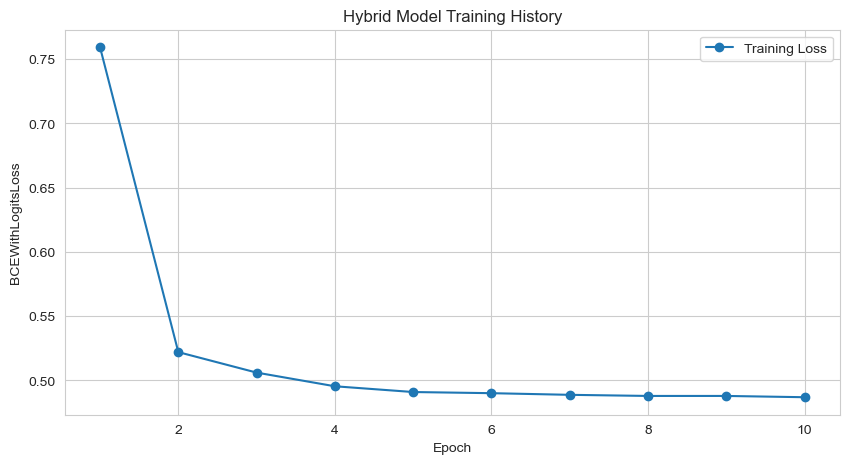

In [22]:
# Cell [6] - Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.title("Hybrid Model Training History")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Cell [7] – Evaluate Hybrid Model

import pandas as pd
import numpy as np
import torch
from pathlib import Path
import sys

# --- Ensure project root is in sys.path ---
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
# -----------------------------------------

# --- Import necessary functions/classes ---
from src import config
from src.data import preprocess  # For time_based_split
from src.evaluation.evaluator import RecEvaluator
# -----------------------------------------

# --- Ensure necessary variables/data are defined ---
if 'hybrid_model' not in locals():
    raise NameError("Hybrid model 'hybrid_model' not defined. Run training cell first.")
if 'user_id_map' not in locals():
    raise NameError("'user_id_map' not defined. Run cell [3] first.")
if 'item_id_map' not in locals():
    raise NameError("'item_id_map' not defined. Run cell [3] first.")
if 'item_features_df' not in locals():
    raise NameError("'item_features_df' not defined. Run cell [2] first.")
if item_features_df.index.name != 'presentation_id':
    raise ValueError("item_features_df must have 'presentation_id' as index.")
# -----------------------------------------------

# --- Load/Recreate the CORRECT Time-Based Train/Test Split ---
print("Loading/Recreating time-based split for evaluation...")
if 'interactions_df' not in locals():
    interactions_df = pd.read_parquet(config.PROCESSED_DATA_DIR / "interactions_final.parquet")

TIME_THRESHOLD = 250  # <<< Make sure this matches the threshold used elsewhere
train_df_eval, test_df_eval = preprocess.time_based_split(
    interactions_df=interactions_df,
    user_col='id_student',
    item_col='presentation_id',
    time_col='last_interaction_date',
    time_unit_threshold=TIME_THRESHOLD
)
print(f"Time-based split ready. Train: {train_df_eval.shape}, Test: {test_df_eval.shape}")
# ------------------------------------------------------------------

# --- Wrapper for Hybrid Model Evaluation ---
class HybridEvaluatorWrapper:
    def __init__(self, hybrid_model, user_map, item_map, item_features_df):
        self.model = hybrid_model
        self.user_id_to_idx = user_map
        self.item_id_to_idx = item_map

        # Copy and check features dataframe
        self.item_features_ref = item_features_df.copy()
        if self.item_features_ref.index.name != 'presentation_id':
            raise ValueError("item_features_df must be indexed by presentation_id")

        # Build mapping: embedding-index -> row-index in features array
        self.item_idx_to_feature_iloc = {
            item_idx: row_iloc
            for row_iloc, item_id in enumerate(self.item_features_ref.index)
            for item_idx in ( [self.item_id_to_idx.get(item_id)] )
            if item_idx is not None
        }

        # Numpy array of all features (in index order)
        self.item_features_array = self.item_features_ref.values.astype(np.float32)
        self.feature_dim = self.item_features_array.shape[1]
        self.device = next(hybrid_model.parameters()).device

    def predict(self, user_id, item_ids):
        """ Predicts scores for a batch of (user_id, item_id)s. """
        user_idx = self.user_id_to_idx.get(user_id)
        if user_idx is None:
            return np.zeros(len(item_ids), dtype=np.float32)

        pred_user_indices = []
        pred_item_indices = []
        pred_item_features = []
        original_pos_map = {}

        for pos, item_id in enumerate(item_ids):
            item_idx = self.item_id_to_idx.get(item_id)
            feat_iloc = self.item_idx_to_feature_iloc.get(item_idx)
            if item_idx is not None and feat_iloc is not None:
                pred_user_indices.append(user_idx)
                pred_item_indices.append(item_idx)
                pred_item_features.append(self.item_features_array[feat_iloc])
                original_pos_map[item_idx] = pos

        if not pred_item_indices:
            return np.zeros(len(item_ids), dtype=np.float32)

        # Convert to tensors
        user_tensor = torch.tensor(pred_user_indices, dtype=torch.long, device=self.device)
        item_tensor = torch.tensor(pred_item_indices, dtype=torch.long, device=self.device)
        feat_tensor = torch.tensor(np.vstack(pred_item_features), dtype=torch.float32, device=self.device)

        # Forward pass
        self.model.eval()
        with torch.no_grad():
            logits = self.model(user_tensor, item_tensor, feat_tensor)

        scores = logits.cpu().numpy()
        final_scores = np.zeros(len(item_ids), dtype=np.float32)
        for idx, score in zip(pred_item_indices, scores):
            final_scores[original_pos_map[idx]] = score

        return final_scores
# ------------------------------------------------------------------

# --- Wrap and Evaluate ---
hybrid_eval_wrapper = HybridEvaluatorWrapper(
    hybrid_model,
    user_id_map,
    item_id_map,
    item_features_df
)
print("Hybrid model wrapped for evaluation.")

if test_df_eval.empty:
    print("\nCannot evaluate Hybrid model: Test data (time-split) is empty.")
else:
    print(f"\nInitializing evaluator with Train: {train_df_eval.shape}, Test: {test_df_eval.shape}")
    hybrid_evaluator = RecEvaluator(
        train_df=train_df_eval,
        test_df=test_df_eval,
        item_features_df=item_features_df,
        user_col='id_student',
        item_col='presentation_id',
        k=config.TOP_K
    )

    print("\n--- Starting Evaluation of Hybrid Model ---")
    hybrid_results = hybrid_evaluator.evaluate_model(hybrid_eval_wrapper, n_neg_samples=100)

    print("\nHybrid Model Evaluation Results:")
    print(hybrid_results)


Loading/Recreating time-based split for evaluation...
Performing time-based split...
Original interactions shape: (28466, 7)
Splitting based on time threshold: last_interaction_date <= 250
 Initial train size: 22892, Initial test size: 5574
Filtered 4836 interactions from test set (users/items not in train).
Final Training set shape: (22892, 7)
Final Test set shape: (738, 7)
Users in Train: 20701, Users in Test: 731
Items in Train: 22, Items in Test: 13
Time-based split ready. Train: (22892, 7), Test: (738, 7)
Hybrid model wrapped for evaluation.

Initializing evaluator with Train: (22892, 7), Test: (738, 7)
Evaluator initialized with 22 unique candidate items.
Stored 20701 training interactions for filtering.
Prepared test data for 731 users.

--- Starting Evaluation of Hybrid Model ---

--- Evaluating Model: HybridEvaluatorWrapper ---


AttributeError: 'HybridEvaluatorWrapper' object has no attribute 'get_known_items'